In [1]:
# Importando bibliotecas necessárias
import json
import numpy as np
import pandas as pd
import math
import sys
import os
import seaborn as sns
from numpy import zeros, array, asarray
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from matplotlib.pyplot import figure
from keras import metrics
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation, SimpleRNN
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [2]:
# Parametros modificados com frequência
debug = True
col_switch = ('summary', 'description')
xcol = col_switch[1]
docs_length = 'mean'
embedding_size = 200
z_score_threshold = 3
z_score_times = 5
lstm = True
dense_layers = True

In [3]:
# Abrindo dados como ndarray
data = []
path = './drive/MyDrive/ColabNotebooks/data/'
filelist = os.listdir(path)
filelist.sort()
# filelist = ['EVL_lab_clean.json']
repo_num = len(filelist)
print("Numero de repositorios: {}".format(repo_num))
for filename in filelist:
  with open(path + filename, 'r') as file:
    repo = json.load(file)
    data += repo
ndata = pd.DataFrame(data).values
pd_data = pd.DataFrame(data)
if debug:
  print(ndata)
  print(ndata.shape)

Numero de repositorios: 70
[['14161' 'ABU'
  list(['contrib-graphic remove body attribute from example.json'])
  list(["i know it's a core model attribute but it's not actually used in this component so it's a little misleading to list it in example.json"])
  '1800' 96.0]
 ['14436' 'ABU' list(['remove readme.pdf'])
  list(["this pdf is hugely and no longer req'd"]) '120' 97.0]
 ['14201' 'ABU' list(['unused color variables'])
  list(['remove from colors.less file or use in theme']) '1800' 97.0]
 ...
 ['10102' 'ZONG' list(["andi's work in"]) nan '3589200' nan]
 ['10010' 'ZONG'
  list(['create diagrams showing the zong modules and their dependencies'])
  nan '9600' nan]
 ['10009' 'ZONG' list(['write guide how to build zong']) nan '11400' nan]]
(97274, 6)


In [4]:
# Convertendo o timespent para float
pd_data['timespent'] = pd_data.timespent.astype(float)

In [5]:
# Removendo linhas com description null
bool_series = pd.notnull(pd_data[xcol]) 

pd_data = pd_data[bool_series]

In [6]:
# Removendo linhas com timespent null
bool_series = pd.notnull(pd_data['timespent']) 

pd_data = pd_data[bool_series]

In [7]:
pd_data

,id,project,summary,description,timespent,alpha
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1800.0,96.0
1,14436,ABU,[remove readme.pdf],[this pdf is hugely and no longer req'd],120.0,97.0
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1800.0,97.0
3,11902,ABU,[review outstanding pull requests],[as per call on sven adding on aniket's behalf],93600.0,97.0
4,15601,ABU,[remove istrackable from adaptmodel.js],[as it isn't actually implemented also remove ...,900.0,98.0
...,...,...,...,...,...,...
97249,10500,UTILS,[clean up],[merge into move all tests to own project test],3600.0,100.0
97250,10400,UTILS,[java se implementation for xmlreader and xmlw...,[create java se implementations for the platfo...,7200.0,100.0
97251,10322,UTILS,[clean up utils],[get rid of integrate them into as far as poss...,14400.0,100.0
97252,10321,UTILS,[java se dependencies in own project],[clean the utils projects from java se depende...,8100.0,100.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


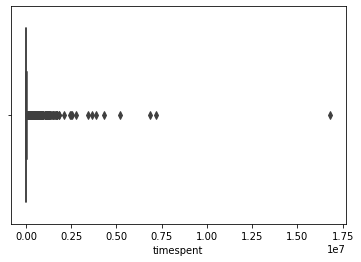

In [8]:
sns.boxplot(pd_data['timespent'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


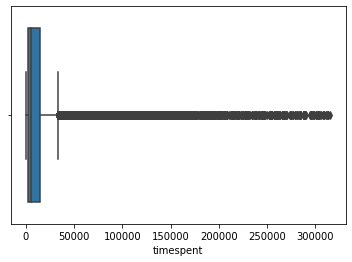

In [9]:
def my_zscore(x):
  return ((x - x.mean())/x.std())

cara =  my_zscore(pd_data['timespent'])
df_sem_outlier_z = pd.DataFrame(
    pd_data[(abs(cara) < z_score_threshold)])
sns.boxplot(df_sem_outlier_z['timespent'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


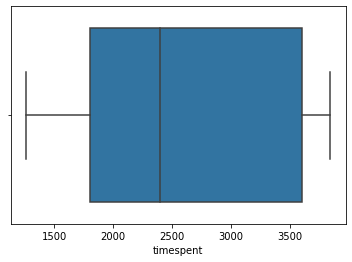

In [10]:
# Aplicando o z score mais vezes para remover mais os outliers
for i in range(z_score_times):
  z_score_threshold = 1
  cara =  my_zscore(df_sem_outlier_z['timespent'])
  df_sem_outlier_z = pd.DataFrame(
      df_sem_outlier_z[(abs(cara) < z_score_threshold)])

sns.boxplot(df_sem_outlier_z['timespent'])

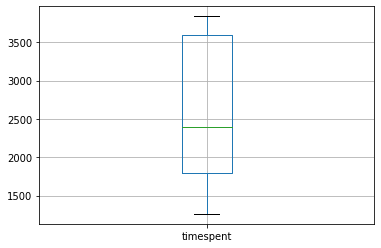

In [11]:
df_sem_outlier_z.boxplot('timespent')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66df73bfd0>]],
      dtype=object)

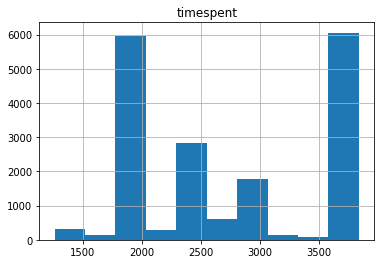

In [12]:
df_sem_outlier_z.hist('timespent')

In [13]:
df_sem_outlier_z

,id,project,summary,description,timespent,alpha
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1800.0,96.0
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1800.0,97.0
7,14251,ABU,[grunt task runner dev task does not copy json...,[the watch task that runs if you do grunt dev ...,1800.0,98.0
8,14121,ABU,[mcq option are read out times if selected],[on this page if any of the options for an mcq...,3600.0,98.0
13,15506,ABU,[narrative component],[the headings for each component item are stac...,1800.0,99.0
...,...,...,...,...,...,...
97240,10006,ZONG,[source code management based on github],[install stash and move the zong and xenoage u...,1800.0,100.0
97245,11500,UTILS,[javafx utils in new project],[move some of the generally useful javafx util...,2700.0,100.0
97248,10501,UTILS,[build server broken],[build server does not work any more restart a...,1890.0,100.0
97249,10500,UTILS,[clean up],[merge into move all tests to own project test],3600.0,100.0


In [14]:
data = df_sem_outlier_z

In [15]:
data

,id,project,summary,description,timespent,alpha
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1800.0,96.0
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1800.0,97.0
7,14251,ABU,[grunt task runner dev task does not copy json...,[the watch task that runs if you do grunt dev ...,1800.0,98.0
8,14121,ABU,[mcq option are read out times if selected],[on this page if any of the options for an mcq...,3600.0,98.0
13,15506,ABU,[narrative component],[the headings for each component item are stac...,1800.0,99.0
...,...,...,...,...,...,...
97240,10006,ZONG,[source code management based on github],[install stash and move the zong and xenoage u...,1800.0,100.0
97245,11500,UTILS,[javafx utils in new project],[move some of the generally useful javafx util...,2700.0,100.0
97248,10501,UTILS,[build server broken],[build server does not work any more restart a...,1890.0,100.0
97249,10500,UTILS,[clean up],[merge into move all tests to own project test],3600.0,100.0


In [16]:
# Categorizando os dados
#data['timespent'] = data.timespent.ge(1200).astype(int)
categories = [0, 1, 2, 3, 4, 5, 6]
data['timespent'] = pd.cut(data['timespent'], bins=len(categories), include_lowest=True, labels=categories).values

In [17]:
data['timespent']

0        1
2        1
7        1
8        6
13       1
        ..
97240    1
97245    3
97248    1
97249    6
97253    6
Name: timespent, Length: 18188, dtype: category
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

In [18]:
# Obtendo todas as palavras das description para serem treinadas
all_text = []
for description in data[xcol].values:
  for des_str in description:
    all_text.append(des_str.split())

if debug:
  print(len(all_text))
  # print(all_text)

41156


In [19]:
# Definindo o modelo de word embeddings
emb_model = Word2Vec(all_text, min_count=10, size=embedding_size)
# Resumo do modelo
if debug:
  print(emb_model)
words = list(emb_model.wv.vocab)
if debug:
  print(words)

vocab_size = len(words) + 1
if debug:
  print(vocab_size)
  print(emb_model.wv.vectors)

Word2Vec(vocab=5282, size=200, alpha=0.025)
['i', 'know', "it's", 'a', 'core', 'model', 'attribute', 'but', 'not', 'actually', 'used', 'in', 'this', 'component', 'so', 'little', 'misleading', 'to', 'list', 'it', 'remove', 'from', 'file', 'or', 'use', 'theme', 'the', 'watch', 'task', 'that', 'runs', 'if', 'you', 'do', 'dev', 'will', 'for', 'changes', 'then', 'copy', 'into', 'build', 'when', 'is', 'changed', 'saved', 'replicate', 'run', 'make', 'change', 'and', 'save', 'observe', 'command', 'line', 'says', 'src', 'course', 'tasks', 'are', 'go', 'has', 'been', 'updated', 'on', 'page', 'any', 'of', 'options', 'an', 'mcq', 'selected', 'ends', 'up', 'being', 'read', 'out', 'times', 'once', 'before', 'twice', 'after', 'indicated', 'headings', 'each', 'item', 'top', 'other', 'see', 'buttons', 'work', 'button', "doesn't", 'also', 'occurs', 'same', 'behaviour', 'nexus', 'android', 'slider', "can't", 'be', 'user', 'unable', 'select', 'submit', 'even', 'scroll', 'must', 'closed', 'reopened', 'can'

In [20]:
# Brincando com o modelo
print(emb_model.wv.similarity('java', 'code'))
emb_model.wv.most_similar(positive=['staging'], topn=10)


0.40013364


[('smtp', 0.9528499841690063),
 ('misc', 0.950731098651886),
 ('smartsense', 0.9494261741638184),
 ('testdb', 0.9487179517745972),
 ('unzip', 0.9465893507003784),
 ('hosting', 0.9463909864425659),
 ('federation', 0.9460157752037048),
 ('gcp', 0.9452401399612427),
 ('groupid', 0.9441858530044556),
 ('feather', 0.9431440830230713)]

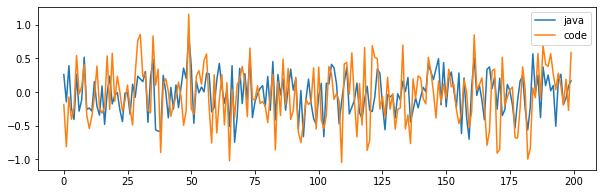

In [21]:
# Comparando vetores de palavras
pyplot.figure(figsize=(10,3))
w1 = 'java'
w2 = 'code'
w1v = emb_model.wv.get_vector(w1)
w2v = emb_model.wv.get_vector(w2)
pyplot.plot(w1v, label=w1)
pyplot.plot(w2v, label=w2)
pyplot.legend()
pyplot.show()

In [22]:
# Obtendo a lista de docs
docs = []
for desc in data[xcol].values:
  sentence_agg = ""
  for sentence in desc:
    sentence_agg += sentence
    sentence_agg += " "
  sentence_agg = sentence_agg.rstrip()
  docs.append(sentence_agg)
print(docs[0:10])
print(len(docs))

["i know it's a core model attribute but it's not actually used in this component so it's a little misleading to list it in example.json", 'remove from colors.less file or use in theme', 'the watch task that runs if you do grunt dev will watch for changes to config.json but then copy config.json into the build when this file is changed saved to replicate run grunt dev make a change to and save the file observe that the command line says file src course config.json changed and that the and copy:coursejson tasks are run go to observe that config.json has not been updated', "on this page if any of the options for an mcq is selected it ends up being read out times once before it's selected and twice after indicated that it's been", "the headings for each component item are stacked on top of each other see buttons and work button doesn't this also occurs in same behaviour on nexus android", "once the slider button is selected it can't be deselected user is then unable to select submit butto

In [23]:
docs_len = []
for doc in docs:
  docs_len.append(len(doc.split()))
print(docs_len[0:10])

[25, 8, 70, 31, 28, 67, 49, 10, 13, 31]


In [24]:
df_sem_outlier_z['lens_sumary'] = docs_len

In [25]:
df_sem_outlier_z

,id,project,summary,description,timespent,alpha,lens_sumary
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1,96.0,25
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1,97.0,8
7,14251,ABU,[grunt task runner dev task does not copy json...,[the watch task that runs if you do grunt dev ...,1,98.0,70
8,14121,ABU,[mcq option are read out times if selected],[on this page if any of the options for an mcq...,6,98.0,31
13,15506,ABU,[narrative component],[the headings for each component item are stac...,1,99.0,28
...,...,...,...,...,...,...,...
97240,10006,ZONG,[source code management based on github],[install stash and move the zong and xenoage u...,1,100.0,41
97245,11500,UTILS,[javafx utils in new project],[move some of the generally useful javafx util...,3,100.0,26
97248,10501,UTILS,[build server broken],[build server does not work any more restart a...,1,100.0,16
97249,10500,UTILS,[clean up],[merge into move all tests to own project test],6,100.0,9


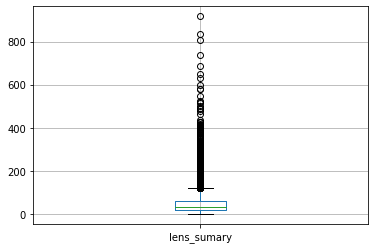

In [26]:
df_sem_outlier_z.boxplot('lens_sumary')

In [27]:
# Tamanho máximo dos docs
max_length_des = 0
if docs_length == 'mean':
  max_length_des = int(df_sem_outlier_z['lens_sumary'].mean())
  if debug:
    print(max_length_des)
elif docs_length == 'min':
  max_length_des = int(df_sem_outlier_z['lens_sumary'].min())
  if debug:
    print(max_length_des)
else:
  for desc in data[xcol].values:
    sentence_size = 0
    for sentence in desc:
      sentence_size += len(sentence.split())
    if sentence_size > max_length_des:
      max_length_des = sentence_size
  if debug:
    print(max_length_des)

46


In [28]:
padded_docs = zeros((len(docs), max_length_des))
for i, doc in enumerate(docs):
  doc_word_list = doc.split()
  doc_encoded = zeros((max_length_des))
  for j, word in enumerate(doc_word_list):
    if j < max_length_des:
      if word in emb_model.wv.vocab:
        doc_encoded[j] = emb_model.wv.vocab[word].index + 1
  padded_docs[i] = doc_encoded
padded_docs     

array([[1.900e+01, 3.640e+02, 2.020e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.380e+02, 2.200e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.878e+03, 1.820e+02, ..., 1.400e+01, 1.000e+00,
        2.440e+02],
       ...,
       [1.070e+02, 9.100e+01, 7.300e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.550e+02, 8.400e+01, 3.440e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.040e+02, 1.000e+00, 3.053e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [29]:
print(padded_docs.shape)

(18188, 46)


In [31]:
# Criando uma matriz de pesos para o vocabulário
embedding_matrix = zeros((vocab_size, embedding_size))
for i, word in enumerate(words):
  embedding_vector = emb_model.wv.get_vector(word)
  if embedding_vector is not None:
    embedding_matrix[i+1] = asarray(embedding_vector, dtype='float32')
  else:
    print("Vish")
if debug:
  print(len(embedding_matrix))
  print(embedding_matrix)

5283
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.25556493e-01 -1.63977909e+00 -1.93185353e+00 ...  8.11469555e-01
   2.43678018e-01 -1.99285597e-01]
 [-6.07347608e-01 -1.38809133e+00 -8.77198577e-01 ... -2.92837918e-01
  -1.01141167e+00 -2.53561437e-01]
 ...
 [ 1.15252770e-02 -1.78568158e-02  2.29712464e-02 ...  5.79613447e-02
  -4.98014316e-02 -1.23599852e-02]
 [ 3.68263423e-02 -6.78586438e-02 -1.10659618e-02 ...  4.60492671e-02
  -8.23905990e-02  1.77690443e-02]
 [-9.41182603e-04 -7.11699128e-02 -2.50581950e-02 ...  3.40346806e-02
  -8.32252577e-02  7.24431174e-03]]


In [32]:
dropout = True
lstm = True
dense_layers = True

In [33]:
# Definindo o modelo
model = Sequential()
e = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_length_des, trainable=False)
model.add(e)
if lstm:
  model.add(Bidirectional(LSTM(embedding_size)))
  if dropout:
    model.add(Dropout(0.3))
else:
  model.add(Flatten())
  if dropout:
    model.add(Dropout(0.1))
if dense_layers:
  model.add(Dense(200, activation='relu'))
  if dropout:  
    model.add(Dropout(0.1))
  model.add(Dense(16, activation='relu'))
  if dropout:
    model.add(Dropout(0.1))
  # model.add(Dense(16, activation='relu'))
  # if dropout:
  #   model.add(Dropout(0.2))
  # model.add(Dense(4, activation='relu'))
  # if dropout:
  #   model.add(Dropout(0.1))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(len(categories), activation='softmax'))
# Compilando o modelo
#opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
# Resumo do modelo
print(model.input_shape)
print(model.summary())

(None, 46)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 46, 200)           1056600   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               80200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                3216      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)      

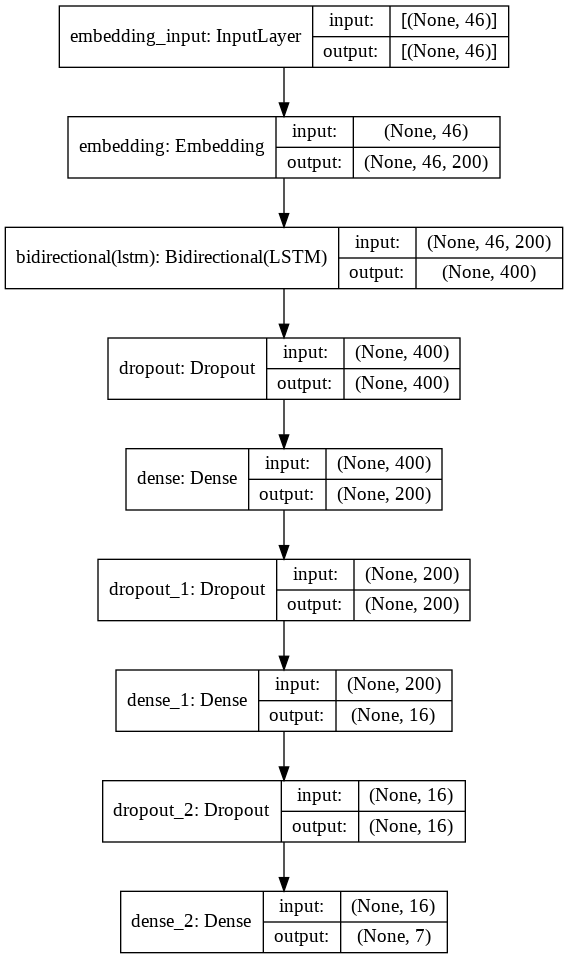

In [34]:
# Plotar modelo em arquivo
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Fold 1 train
Epoch 1/10
231/231 [==============================] - 77s 328ms/step - loss: 1.3468 - accuracy: 0.3799 - val_loss: 1.7445 - val_accuracy: 0.3128
Epoch 2/10
231/231 [==============================] - 76s 330ms/step - loss: 1.3310 - accuracy: 0.3892 - val_loss: 1.7798 - val_accuracy: 0.2902
Epoch 3/10
231/231 [==============================] - 76s 330ms/step - loss: 1.3159 - accuracy: 0.3975 - val_loss: 1.8518 - val_accuracy: 0.3183
Epoch 4/10
231/231 [==============================] - 75s 323ms/step - loss: 1.2939 - accuracy: 0.4073 - val_loss: 1.8346 - val_accuracy: 0.3067
Epoch 5/10
231/231 [==============================] - 78s 336ms/step - loss: 1.2663 - accuracy: 0.4230 - val_loss: 1.8926 - val_accuracy: 0.3280
Epoch 6/10
231/231 [==============================] - 80s 345ms/step - loss: 1.2354 - accuracy: 0.4380 - val_loss: 1.9544 - val_accuracy: 0.2926
Epoch 7/10
231/231 [==============================] - 82s 357ms/step - loss: 1.1942 - accuracy: 0.4588 - val_loss: 2.

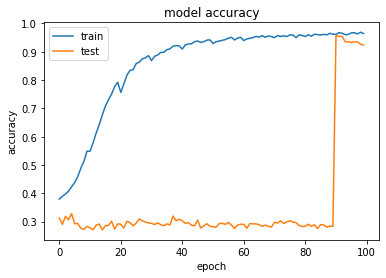

In [ ]:
from keras.backend import clear_session
clear_session()
# Treinando o modelo

from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
foldn = 1
acc_hist = []
acc_val_hist = []
for train_index, _ in kf.split(padded_docs):
  x_train = padded_docs[train_index]
  y_train = data['timespent'].values.codes[train_index]

  print("Fold {} train".format(foldn))
  foldn += 1

  history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
  
  acc_hist.extend(history.history['accuracy'])
  acc_val_hist.extend(history.history['val_accuracy'])

pyplot.plot(acc_hist)
pyplot.plot(acc_val_hist)
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [ ]:
# Particionando conjunto de teste e treino para avaliação
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(padded_docs, data['timespent'].values.codes, test_size=0.2, random_state=4)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(14550, 46)
(3638, 46)
(14550,)
(3638,)


In [ ]:
# Avaliando o modelo
print('Treino')
loss, metric = model.evaluate(x_train, y_train)
print('Loss: {}'.format(loss))
print('Metric: {}'.format(metric))
print('Test')
loss, metric = model.evaluate(x_test, y_test)
print('Loss: {}'.format(loss))
print('Metric: {}'.format(metric))

Treino
455/455 [==============================] - 33s 72ms/step - loss: 0.6783 - accuracy: 0.9158
Loss: 0.6782582998275757
Metric: 0.9158075451850891
Test
114/114 [==============================] - 8s 72ms/step - loss: 0.6405 - accuracy: 0.9244
Loss: 0.6404592394828796
Metric: 0.924409031867981


In [ ]:
# Fazendo e avaliando previsões
predictions = model.predict(x_test)
print(predictions[0])
pred_class = []
for pred in predictions:
  pred_class.append(np.argmax(pred))

[1.6893682e-13 9.9993384e-01 6.0137583e-13 1.1537283e-05 1.8992026e-08
 3.4293084e-13 5.4605724e-05]


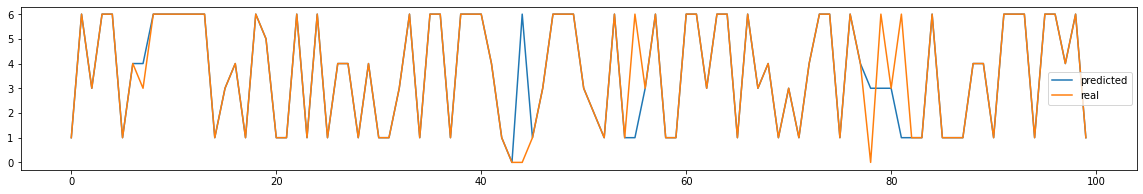

In [ ]:
pred_to_plot = pred_class
psize = 100
pyplot.figure(figsize=(20,3))
pyplot.plot(pred_to_plot[0:psize], label='predicted')
pyplot.plot(y_test[0:psize], label='real')
pyplot.legend()
pyplot.show()

In [ ]:
# Calculando mmre and mae para validação
from sklearn.metrics import mean_absolute_error

def mre(actual, pred):
  actual += 1
  pred += 1
  mre = (abs(actual - pred)) / actual
  return mre

def mmre(y, pred):
  sum = 0.0
  for i, actual in enumerate(y):
    sum += mre(actual, pred[i])
  mmre = (sum / (len(y))) 
  return mmre

print("MMRE: {}".format(mmre(y_test, pred_class)))
print("MAE: {}".format(mean_absolute_error(y_test, pred_class)))

MMRE: 0.08850428021675968
MAE: 0.24766355140186916


[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4'),
 Text(0, 5.5, '5'),
 Text(0, 6.5, '6')]

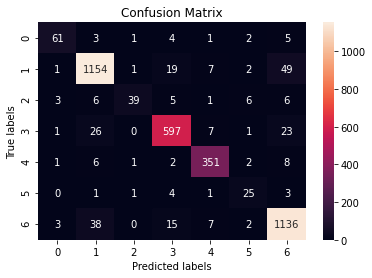

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt    
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_class, categories) 

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(categories) 
ax.yaxis.set_ticklabels(categories)

In [ ]:
# Old figure of confusion matrix
# fig = pyplot.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# pyplot.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# pyplot.xlabel('Predicted')
# pyplot.ylabel('True')
# pyplot.show()

In [ ]:
# pyplot.plot(history.history['mae'])
# pyplot.plot(history.history['val_mae'])
# pyplot.title('model accuracy')
# pyplot.ylabel('mae')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'test'], loc='upper left')
# pyplot.show()

In [ ]:
# # Primeiro Quartil
# Q1 = pd_data['timespent'].quantile(0.25)
# print("Q1: {}".format(Q1))
# # Segundo Quartil
# Q2 = pd_data['timespent'].quantile(0.50)
# print("Q2: {}".format(Q2))
# # Terceiro Quartil
# Q3 = pd_data['timespent'].quantile(0.75)
# print("Q3: {}".format(Q3))
# # Amplitude Interquartil
# IQR = Q3 - Q1
# print("IQR: {}".format(IQR))
# # Limite Superior
# LI = Q1 - (1.5 * IQR)
# print("LI: {}".format(LI))
# # Limite Inferior
# LS = Q3 + (1.5 * IQR)
# print("LS: {}".format(LS))

In [ ]:
# df_sem_outlier = pd.DataFrame(
#     pd_data[(
#         (pd_data['timespent'] >= LI) 
#         & (pd_data['timespent'] <= LS)
#     )])

# sns.boxplot(df_sem_outlier['timespent'])

In [ ]:
# for pred in predictions:
#     if pred != 1089.0886 and pred != 1089.0885:
#       print(pred)

In [ ]:
# # Visualizando o word embedding
# X = emb_model[emb_model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# fig, ax = pyplot.subplots()
# ax.scatter(result[:, 0], result[:, 1])
# xlim1 = -0.200
# xlim2 = -0.125
# ylim1 = -0.02
# ylim2 = 0.02
# limits = False

# words = list(emb_model.wv.vocab)
# for i, word in enumerate(words):
#   x = result[i, 0]
#   y = result[i, 1]
#   if limits:
#     if x >= xlim1 and x <= xlim2 and y >= ylim1 and y <= ylim2: 
# 	    ax.annotate(word, xy=(x, y))
#   else:
#     ax.annotate(word, xy=(x, y))

# if limits:
#   ax.set_xlim(xlim1, xlim2)
#   ax.set_ylim(ylim1, ylim2)

In [ ]:
# prepare tokenizer
# t = Tokenizer()
# t.fit_on_texts(summary_list)
# vocab_size = len(t.word_index) + 1
# print(vocab_size)

In [ ]:
# integer encode the documents
# encoded_docs = t.texts_to_sequences(summary_list)
# print(encoded_docs)

In [ ]:
# padded_docs = pad_sequences(encoded_docs, maxlen=max_summary_length, padding='post')
# print(padded_docs)

In [ ]:
# ss = StandardScaler()
# sclWord = ss.fit(emb_model.wv.vectors)
# vectors_normalized = sclWord.transform(vocab_dict.values())

# vectors_list = []
# for word in emb_model.wv.vocab:
#   vectors_list.append(emb_model.wv.get_vector(word))

# print(type(emb_model.wv.vocab))
# embeddings_index = dict()
# for i, word in enumerate(list(emb_model.wv.vocab)[0:10]):
#   print(emb_model.wv.vectors[i])
#   print(vectors_list[i])
	#embeddings_index[word] = vectors_normalized[i]

In [ ]:
# count = 0
# for cara in embedding_matrix:
#   if cara[0] == 0:
#     count+=1
# print(count)